In [1]:
!git clone https://github.com/hpcaitech/ColossalAI.git
!cd ColossalAI
# install dependency
!pip install -r ColossalAI/requirements/requirements.txt
# install colossalai
!pip install ColossalAI/

Cloning into 'ColossalAI'...
remote: Enumerating objects: 41534, done.
remote: Counting objects: 100% (1964/1964), done.
remote: Compressing objects: 100% (1321/1321), done.
remote: Total 41534 (delta 1073), reused 1275 (delta 631), pack-reused 39570
Receiving objects: 100% (41534/41534), 30.04 MiB | 10.21 MiB/s, done.
Resolving deltas: 100% (27912/27912), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 82.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

Processing ./ColossalAI
  Preparing metadata (setup.py) ... done
  Created wheel for colossalai: filename=colossalai-0.3.6-py3-none-any.whl size=1550336 sha256=27db0949b0e566217681f1cd360a9d805903bfd150b95227dcae6a8fa81cb54f
  Stored in directory: /tmp/pip-ephem-wheel-cache-9q0rdxez/wheels/b1/fb/16/e46aa3127ee272b8cac710c8f76aa02445d96aaeed9da956ea
Successfully built colossalai


In [4]:
!pip install datasets

In [5]:
from data import GLUEDataBuilder_Modified

In [6]:
import torch
import colossalai
from colossalai.context import Config

In [7]:
# initialize distributed
CONFIG = Config(
    dict(
        parallel=dict(
            data=dict(size=1),
            pipeline=dict(size=1),
            tensor=dict(size=1, mode=None),
            )
        )
    )
colossalai.launch(config=CONFIG,
                  rank=0,
                  world_size=1,
                  host='127.0.0.1',
                  port=8888,
                  backend='nccl')

/usr/local/lib/python3.10/dist-packages/colossalai/initialize.py:48: UserWarning: `config` is deprecated and will be removed soon.
  warnings.warn("`config` is deprecated and will be removed soon.")


[04/10/24 05:21:58] INFO     colossalai - colossalai - INFO:                                                       
                             /usr/local/lib/python3.10/dist-packages/colossalai/initialize.py:67 launch

                    INFO     colossalai - colossalai - INFO: Distributed environment is initialized, world size: 1

In [8]:
from typing import Callable, List, Union
import torch.distributed as dist
import torch.nn as nn
from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler as LRScheduler
from tqdm import tqdm
from transformers import AutoConfig, GPT2ForSequenceClassification, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, PreTrainedTokenizer
from torch.utils.data import DataLoader
import datasets

from colossalai.accelerator import get_accelerator
from colossalai.booster import Booster
from colossalai.booster.plugin import GeminiPlugin, HybridParallelPlugin, LowLevelZeroPlugin, TorchDDPPlugin
from colossalai.cluster import DistCoordinator
from colossalai.nn.optimizer import HybridAdam


In [14]:
# ==============================
# Prepare Hyperparameters
# ==============================
NUM_EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 2.4e-5
WEIGHT_DECAY = 0.01
WARMUP_FRACTION = 0.1

output_transform_fn = lambda x: x
criterion = lambda x: x.loss

def move_to_cuda(batch):
    return {k: v.cuda() for k, v in batch.items()}

In [15]:
plugin = TorchDDPPlugin()
coordinator = DistCoordinator()
lr = LEARNING_RATE * coordinator.world_size

In [16]:
data_builder = GLUEDataBuilder_Modified(
        'gpt2', plugin, 'mrpc', train_batch_size=BATCH_SIZE, eval_batch_size=BATCH_SIZE
    )
train_dataloader = data_builder.train_dataloader()
test_dataloader = data_builder.test_dataloader()

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

In [17]:
cfg = AutoConfig.from_pretrained("gpt2", num_labels=2)
model_gpt = GPT2ForSequenceClassification.from_pretrained("gpt2", config=cfg).cuda()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
lr = LEARNING_RATE * coordinator.world_size
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model_gpt.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": WEIGHT_DECAY,
    },
    {
        "params": [p for n, p in model_gpt.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]

In [19]:
optimizer = HybridAdam(optimizer_grouped_parameters, lr=lr, eps=1e-8)

[extension] Compiling the JIT cpu_adam_x86 kernel during runtime now


/usr/local/lib/python3.10/dist-packages/colossalai/kernel/extensions/utils.py:96: UserWarning: [extension] The CUDA version on the system (12.2) does not match with the version (12.1) torch was compiled with. The mismatch is found in the minor version. As the APIs are compatible, we will allow compilation to proceed. If you encounter any issue when using the built kernel, please try to build it again with fully matched CUDA versions
  warnings.warn(


[extension] Time taken to compile cpu_adam_x86 op: 39.25519800186157 seconds
[extension] Compiling the JIT fused_optim_cuda kernel during runtime now


/usr/local/lib/python3.10/dist-packages/colossalai/kernel/extensions/utils.py:96: UserWarning: [extension] The CUDA version on the system (12.2) does not match with the version (12.1) torch was compiled with. The mismatch is found in the minor version. As the APIs are compatible, we will allow compilation to proceed. If you encounter any issue when using the built kernel, please try to build it again with fully matched CUDA versions
  warnings.warn(


[extension] Time taken to compile fused_optim_cuda op: 252.247629404068 seconds


/usr/local/lib/python3.10/dist-packages/colossalai/nn/optimizer/hybrid_adam.py:90: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  self._dummy_overflow_buf = torch.cuda.IntTensor([0])


In [20]:
# lr scheduler
total_steps = len(train_dataloader) * NUM_EPOCHS
num_warmup_steps = int(WARMUP_FRACTION * total_steps)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=total_steps,
)

def _criterion(outputs, inputs):
        outputs = output_transform_fn(outputs)
        loss = criterion(outputs)
        return loss


In [21]:
booster = Booster(plugin=plugin)

In [22]:
model_gpt.resize_token_embeddings(len(data_builder.tokenizer))
model_gpt.config.pad_token_id = 0

In [23]:
model, optimizer, _criterion, _, lr_scheduler = booster.boost(
    model_gpt, optimizer, criterion=_criterion, lr_scheduler=lr_scheduler
)

In [24]:
def train_epoch(
    epoch: int,
    model: nn.Module,
    optimizer: Optimizer,
    _criterion: Callable,
    lr_scheduler: LRScheduler,
    train_dataloader: DataLoader,
    booster: Booster,
    coordinator: DistCoordinator,
):
    use_pipeline = isinstance(booster.plugin, HybridParallelPlugin) and booster.plugin.pp_size > 1
    is_pp_last_device = use_pipeline and booster.plugin.stage_manager.is_last_stage(ignore_chunk=True)
    print_flag = (not use_pipeline and coordinator.is_master()) or (use_pipeline and is_pp_last_device)
    total_step = len(train_dataloader)
    predictions = []
    total_loss = 0
    total_correct_predictions = 0
    total_sample = 0

    model.train()
    optimizer.zero_grad()
    train_dataloader_iter = iter(train_dataloader)
    with tqdm(range(total_step), desc=f"Epoch [{epoch + 1}/{NUM_EPOCHS}]", disable=not print_flag) as pbar:
        # Forward pass
        for _ in pbar:
            data = next(train_dataloader_iter)
            data = move_to_cuda(data)
            outputs = model(**data)
            loss = _criterion(outputs, None)
            # Backward
            booster.backward(loss, optimizer)
            pbar.set_postfix({"loss": loss.item()})

            logits = outputs[1]
            preds = torch.argmax(logits, axis=1)
            predictions.append(preds)
            total_loss = total_loss + loss.item()

            correct_predictions = (preds == data['labels']).sum().item()
            total_correct_predictions += correct_predictions
            total_sample += preds.shape[0]

            optimizer.step()
            optimizer.zero_grad()
            lr_scheduler.step()
    avg_loss = total_loss / total_step
    avg_acc = total_correct_predictions / total_sample
    return avg_loss, predictions, avg_acc

In [25]:
train_losses=[]
train_accs=[]
for epoch in range(NUM_EPOCHS):
    train_loss, train_prediction, train_acc = train_epoch(epoch, model, optimizer, _criterion, lr_scheduler, train_dataloader, booster, coordinator)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'\nTraining Accuracy: {train_acc:.5f}')

Epoch [1/5]:   0%|          | 0/114 [00:01<?, ?it/s, loss=1.73]/usr/local/lib/python3.10/dist-packages/colossalai/nn/optimizer/nvme_optimizer.py:55: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  numel += p.storage().size()
Epoch [1/5]: 100%|██████████| 114/114 [01:20<00:00,  1.42it/s, loss=0.586]



Training Loss: 0.788

Training Accuracy: 0.66667


Epoch [2/5]: 100%|██████████| 114/114 [01:18<00:00,  1.45it/s, loss=0.484]



Training Loss: 0.583

Training Accuracy: 0.70422


Epoch [3/5]: 100%|██████████| 114/114 [01:18<00:00,  1.45it/s, loss=0.488]



Training Loss: 0.535

Training Accuracy: 0.72834


Epoch [4/5]: 100%|██████████| 114/114 [01:18<00:00,  1.45it/s, loss=0.415]



Training Loss: 0.490

Training Accuracy: 0.76974


Epoch [5/5]: 100%|██████████| 114/114 [01:18<00:00,  1.45it/s, loss=0.363]


Training Loss: 0.457

Training Accuracy: 0.78536


In [28]:
for epoch in range(3):
    train_loss, train_prediction, train_acc = train_epoch(epoch, model, optimizer, _criterion, lr_scheduler, train_dataloader, booster, coordinator)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'\nTraining Accuracy: {train_acc:.5f}')

Epoch [1/5]: 100%|██████████| 114/114 [01:19<00:00,  1.44it/s, loss=0.43]



Training Loss: 0.450

Training Accuracy: 0.79359


Epoch [2/5]: 100%|██████████| 114/114 [01:18<00:00,  1.45it/s, loss=0.452]



Training Loss: 0.450

Training Accuracy: 0.79276


Epoch [3/5]: 100%|██████████| 114/114 [01:18<00:00,  1.45it/s, loss=0.347]


Training Loss: 0.445

Training Accuracy: 0.79167


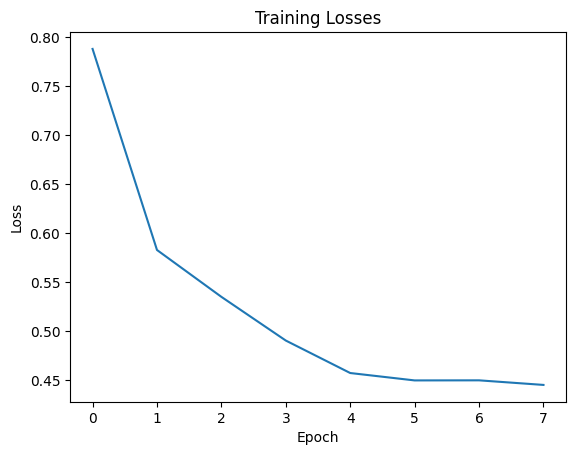

In [29]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.show()

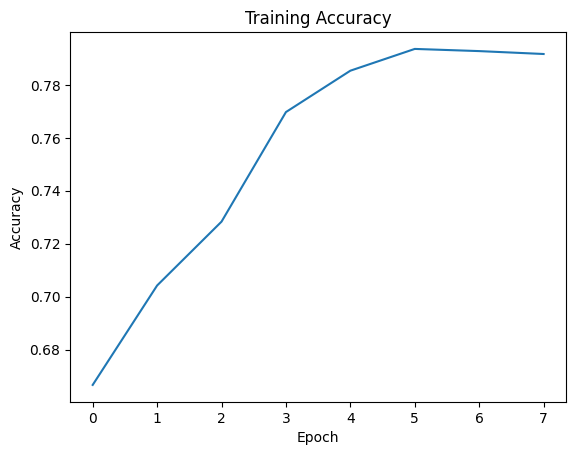

In [30]:
plt.plot(train_accs, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.show()

In [31]:
def evaluate(
    model: nn.Module,
    _criterion: Callable,
    test_dataloader: DataLoader,
    booster: Booster,
):
    model.eval()
    test_predictions = []
    test_total_loss = 0
    test_total_correct_predictions = 0
    test_total_sample = 0
    test_dataloader_iter = iter(test_dataloader)

    with tqdm(range(len(test_dataloader))) as pbar:
        for _ in pbar:
          data = next(test_dataloader_iter)
          data = move_to_cuda(data)
          labels = data['labels']
          outputs = model(**data)

          val_loss = _criterion(outputs, None)
          pbar.set_postfix({"val loss": val_loss.item()})
          logits = outputs[1]

          preds = torch.argmax(logits, axis=1)
          test_predictions.append(preds)
          test_total_loss += val_loss.item()

          correct_predictions = (preds == labels).sum().item()
          test_total_correct_predictions += correct_predictions
          test_total_sample += preds.shape[0]
    test_avg_loss = test_total_loss / len(test_dataloader)
    test_avg_acc = test_total_correct_predictions / test_total_sample
    return test_avg_loss, test_avg_acc

In [32]:
test_avg_loss, test_avg_acc = evaluate(model, _criterion, test_dataloader, booster)

100%|██████████| 54/54 [00:12<00:00,  4.21it/s, val loss=0.444]


In [33]:
print(f'\nTesting Loss: {test_avg_loss:.3f}')
print(f'\nTesting Accuracy: {test_avg_acc:.5f}')


Testing Loss: 0.480

Testing Accuracy: 0.77391
